# Disciple - 取引シミュレーション（Jupyter用）

In [1]:
import datetime
import os
import re

import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import griddata

from funcs.conv import conv_transaction_df2html
from funcs.setting import load_setting
from funcs.tide import get_date_dir_from_file
from funcs.tse import get_ticker_name_list
from modules.disciple import Disciple
from structs.res import AppRes

In [2]:
# デバッグモード
debug = False

res = AppRes()
excel = "ticks_20260121.xlsx"
# code = "285A"
code = "7011"
# code = "7203"
# code = "8306"
# code = "9984"
dict_setting = load_setting(res, code)
THRESHOLD_SLOPE = dict_setting["THRESHOLD_SLOPE"]
TURBULENCE = dict_setting["TURBULENCE"]
THRESHOLD_PM_MIN = dict_setting["THRESHOLD_PM_MIN"]
THRESHOLD_DDR_MIN = dict_setting["THRESHOLD_DDR_MIN"]
date_str = get_date_dir_from_file(excel)
print(date_str)

app = Disciple(excel, code, dict_setting)
app.run()

2026\01\21
パラメータ
PERIOD_WARMUP : 180
PERIOD_MA_1 : 40
PERIOD_MA_2 : 1400
PERIOD_SLOPE : 5
THRESHOLD_SLOPE : 0.05
PERIOD_RR : 30
TURBULENCE : 35.0
LOSSCUT_1 : -25
THRESHOLD_PM_MIN : 10.0
THRESHOLD_DDR_MIN : 0.6
N_MINUS_MAX : 180


In [3]:
# 取引明細
df_transaction = app.getTransaction()
df_transaction["累積損益"] = df_transaction["損益"].fillna(0).cumsum()
print("取引明細")
print(df_transaction)
print(df_transaction["注文日時"].dtype)
print(df_transaction["累積損益"].dtype)

list_html = conv_transaction_df2html(df_transaction)

if debug:
    output_dir = os.path.join("tmp", date_str)
else:
    output_dir = os.path.join("output", date_str)

os.makedirs(output_dir, exist_ok=True)
output = os.path.join(output_dir, f"{code}_transaction.html")
print(output)
with open(output, mode="w") as f:
    f.write("\n".join(list_html))

list_trans = df_transaction["注文日時"]
n_trade = len(df_transaction)
total = df_transaction["損益"].sum()
print(f"取引回数: {n_trade} 回 / 総収益: {total} 円/株")

取引明細
    注文番号                          注文日時 銘柄コード  売買  約定単価  約定数量     損益 備考    累積損益
0      1 2026-01-21 09:15:35.709372044  7011  売建  4757   100    NaN        0.0
1      2 2026-01-21 09:16:38.952451944  7011  買埋  4750   100  700.0      700.0
2      3 2026-01-21 09:18:17.187366962  7011  買建  4760   100    NaN      700.0
3      4 2026-01-21 09:18:58.315701008  7011  売埋  4757   100 -300.0      400.0
4      5 2026-01-21 09:18:59.322422028  7011  売建  4758   100    NaN      400.0
..   ...                           ...   ...  ..   ...   ...    ... ..     ...
59    60 2026-01-21 15:22:19.350364923  7011  売埋  4807   100 -900.0     2600.0
60    61 2026-01-21 15:22:20.359538078  7011  売建  4808   100    NaN     2600.0
61    62 2026-01-21 15:23:19.462212086  7011  買埋  4812   100 -400.0     2200.0
62    63 2026-01-21 15:23:20.470108986  7011  買建  4811   100    NaN     2200.0
63    64 2026-01-21 15:24:49.693861008  7011  売埋  4816   100  500.0     2700.0

[64 rows x 9 columns]
datetime64[ns]
float64
o

In [4]:
# Matplotlib の共通設定
FONT_PATH = "fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()

In [5]:
"""
累積損益のトレンドを作成するための準備
"""

# 元データ
ts = df_transaction["注文日時"]
pl = df_transaction["累積損益"]

# 日付（年月日）だけ取り出す
date = ts.iloc[0].normalize()

# 追加する先頭と末尾の行
start_row = pd.DataFrame(
    {
        "注文日時": [date + pd.Timedelta(hours=9)],
        "累積損益": [0.0],
    }
)

end_row = pd.DataFrame(
    {
        "注文日時": [date + pd.Timedelta(hours=15, minutes=30)],
        "累積損益": [pl.iloc[-1]],
    }
)

# トレンド用 DataFrame を作成
trend_df = pd.concat(
    [start_row, df_transaction[["注文日時", "累積損益"]], end_row], ignore_index=True
)

# 注文日時を index にした Series を作成
trend_series = trend_df.set_index("注文日時")["累積損益"]
trend_series

注文日時
2026-01-21 09:00:00.000000000       0.0
2026-01-21 09:15:35.709372044       0.0
2026-01-21 09:16:38.952451944     700.0
2026-01-21 09:18:17.187366962     700.0
2026-01-21 09:18:58.315701008     400.0
                                  ...  
2026-01-21 15:22:20.359538078    2600.0
2026-01-21 15:23:19.462212086    2200.0
2026-01-21 15:23:20.470108986    2200.0
2026-01-21 15:24:49.693861008    2700.0
2026-01-21 15:30:00.000000000    2700.0
Name: 累積損益, Length: 66, dtype: float64

output\2026\01\21\7011_trend_profit.png


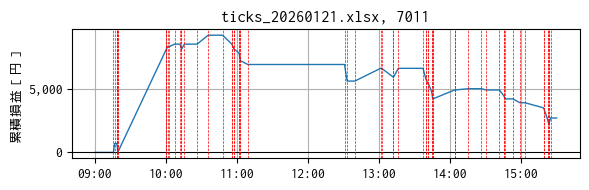

In [6]:
# 累積損益トレンド
fig, ax = plt.subplots(figsize=(6, 2))

ax.set_title(f"{excel}, {code}")
ax.plot(trend_series, linewidth=1)
ax.axhline(y=0, color="black", linewidth=0.75)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax.set_ylabel("累積損益［円］")
for t in list_trans:
    ax.axvline(x=t, color="red", linestyle="dashed", linewidth=0.5)
ax.grid()

plt.tight_layout()
output = os.path.join(output_dir, f"{code}_trend_profit.png")
print(output)
plt.savefig(output)
plt.show()

In [7]:
# テクニカル指標
print("テクニカル指標")
df_tech = app.getTechnicals()
print(df_tech)

テクニカル指標
                               ts  price       ma1          ma2  mr  \
2026-01-21 09:02:51  1.768954e+09   4747  4747.000  4747.000000   0   
2026-01-21 09:02:52  1.768954e+09   4747  4747.000  4747.000000   0   
2026-01-21 09:02:53  1.768954e+09   4747  4747.000  4747.000000   0   
2026-01-21 09:02:54  1.768954e+09   4747  4747.000  4747.000000   0   
2026-01-21 09:02:55  1.768954e+09   4755  4748.600  4748.600000   8   
...                           ...    ...       ...          ...  ..   
2026-01-21 15:24:45  1.768977e+09   4817  4816.325  4810.425000  14   
2026-01-21 15:24:46  1.768977e+09   4817  4816.350  4810.426429  14   
2026-01-21 15:24:47  1.768977e+09   4816  4816.350  4810.427143  14   
2026-01-21 15:24:48  1.768977e+09   4816  4816.350  4810.427857  14   
2026-01-21 15:24:49  1.768977e+09   4816  4816.350  4810.428571  14   

                     disparity    slope1  rr  profit  profit_max  drawdown  \
2026-01-21 09:02:51   0.000000  0.000000   0     0.0         

In [8]:
df_tech["slope1"].describe()

count    19257.000000
mean         0.079758
std          0.101030
min          0.000000
25%          0.025000
50%          0.050000
75%          0.100000
max          1.982169
Name: slope1, dtype: float64

output\2026\01\21\7011_trend_technical.png


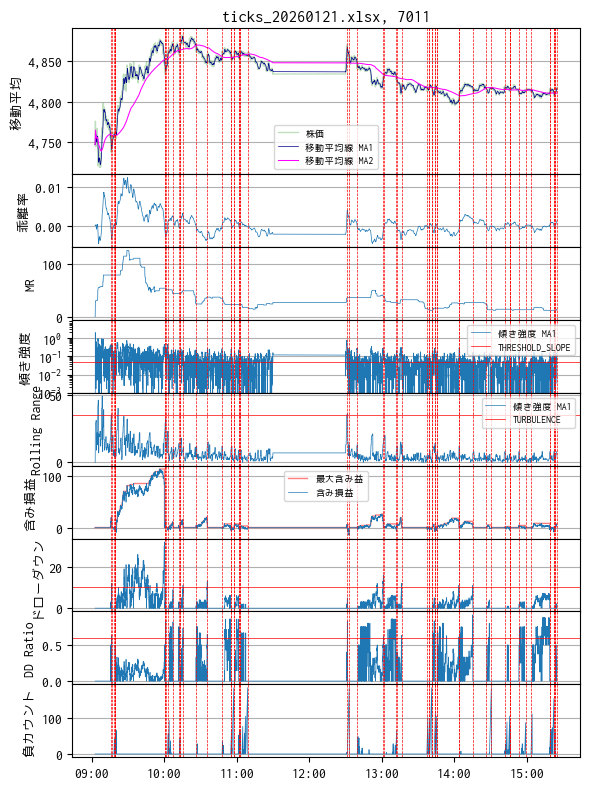

In [9]:
fig = plt.figure(figsize=(6, 8))
n = 9
ax = dict()
gs = fig.add_gridspec(
    n, 1, wspace=0.0, hspace=0.0, height_ratios=[2 if i == 0 else 1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex="col")):
    ax[i] = axis
    ax[i].grid(axis="y")

ax[0].set_title(f"{excel}, {code}")
ax[0].plot(df_tech["price"], linewidth=1, color="green", alpha=0.25, label="株価")
ax[0].plot(df_tech["ma1"], linewidth=0.5, color="darkblue", label="移動平均線 MA1")
ax[0].plot(df_tech["ma2"], linewidth=0.75, color="magenta", label="移動平均線 MA2")
ax[0].set_ylabel("移動平均")
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax[0].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax[0].legend(fontsize=7)

ax[1].plot(df_tech["disparity"], linewidth=0.5, label="MA乖離率")
ax[1].set_ylabel("乖離率")

ax[2].plot(df_tech["mr"], linewidth=0.5, label="移動範囲")
ax[2].set_ylabel("MR")

ax[3].plot(df_tech["slope1"], linewidth=0.5, label="傾き強度 MA1")
ax[3].axhline(y=THRESHOLD_SLOPE, color="red", linewidth=0.5, label="THRESHOLD_SLOPE")
ax[3].set_yscale("log")
ax[3].set_ylabel("傾き強度")
ax[3].legend(fontsize=7)
_, y_high = ax[3].get_ylim()
ax[3].set_ylim(0.001, y_high)

ax[4].plot(df_tech["rr"], linewidth=0.5, label="傾き強度 MA1")
ax[4].axhline(y=TURBULENCE, color="red", linewidth=0.5, label="TURBULENCE")
ax[4].set_ylabel("Rolling Range")
ax[4].legend(fontsize=7)

ax[5].plot(
    df_tech["profit_max"], linewidth=1, color="red", alpha=0.5, label="最大含み益"
)
ax[5].plot(df_tech["profit"], linewidth=0.5, color="C0", label="含み損益")
ax[5].set_ylabel("含み損益")
ax[5].legend(fontsize=7)

ax[6].plot(df_tech["drawdown"], linewidth=0.5)
ax[6].axhline(y=THRESHOLD_PM_MIN, color="red", linewidth=0.5, label="THRESHOLD_PM_MIN")
ax[6].set_ylabel("ドローダウン")

ax[7].plot(df_tech["dd_ratio"], linewidth=0.5)
ax[7].axhline(
    y=THRESHOLD_DDR_MIN, color="red", linewidth=0.5, label="THRESHOLD_DDR_MIN"
)
ax[7].set_ylabel("DD Ratio")

ax[8].plot(df_tech["n_minus"], linewidth=0.5)
ax[8].set_ylabel("負カウント")

for i in range(n):
    for t in list_trans:
        ax[i].axvline(x=t, color="red", linestyle="dashed", linewidth=0.5)

plt.tight_layout()
output = os.path.join(output_dir, f"{code}_trend_technical.png")
print(output)
plt.savefig(output)
plt.show()

output\2026\01\21\7011_hist_slope.png


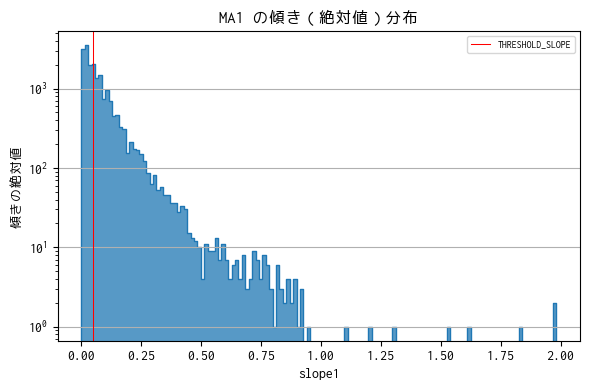

In [10]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("MA1 の傾き（絶対値）分布")
sns.histplot(data=df_tech, x="slope1", bins="sqrt", element="step")
ax.axvline(x=THRESHOLD_SLOPE, color="red", linewidth=0.75, label="THRESHOLD_SLOPE")
ax.set_yscale("log")
ax.set_ylabel("傾きの絶対値")
ax.grid(axis="y")
ax.legend(fontsize=7)

plt.tight_layout()
output = os.path.join(output_dir, f"{code}_hist_slope.png")
print(output)
plt.savefig(output)
plt.show()

output\2026\01\21\7011_hist_rr.png


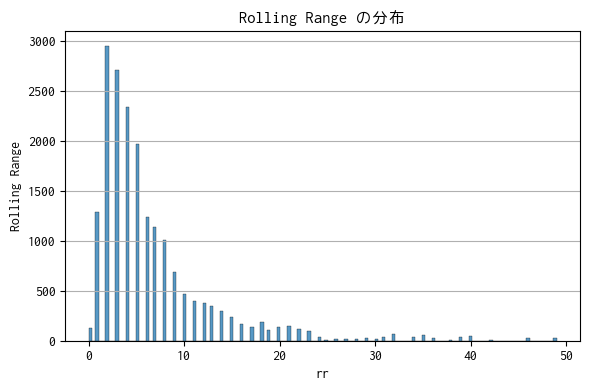

In [11]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("Rolling Range の分布")
sns.histplot(data=df_tech, x="rr", bins="sqrt")
# ax.axvline(x=THRESHOLD_SLOPE, color="red", linewidth=0.75, label="THRESHOLD_SLOPE")
# ax.set_yscale("log")
ax.set_ylabel("Rolling Range")
ax.grid(axis="y")
# ax.legend(fontsize=7)

plt.tight_layout()
output = os.path.join(output_dir, f"{code}_hist_rr.png")
print(output)
plt.savefig(output)
plt.show()

In [12]:
# 観測値
print("観測値")
df_obs = app.getObservations()
print(df_obs)

観測値
                     クロスS1  クロスS2  クロ強  乱高下  ロス1  ロス2  利確1   建玉
2026-01-21 09:02:51    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0
2026-01-21 09:02:52    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0
2026-01-21 09:02:53    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0
2026-01-21 09:02:54    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0
2026-01-21 09:02:55    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0
...                    ...    ...  ...  ...  ...  ...  ...  ...
2026-01-21 15:24:45    0.0    0.0  0.0  0.0  0.0  0.0  0.0  1.0
2026-01-21 15:24:46    0.0    0.0  0.0  0.0  0.0  0.0  0.0  1.0
2026-01-21 15:24:47    0.0    0.0  0.0  0.0  0.0  0.0  0.0  1.0
2026-01-21 15:24:48    0.0    0.0  0.0  0.0  0.0  0.0  0.0  1.0
2026-01-21 15:24:49    0.0    0.0  0.0  0.0  0.0  0.0  0.0  1.0

[19257 rows x 8 columns]


output\2026\01\21\7011_trend_obs.png


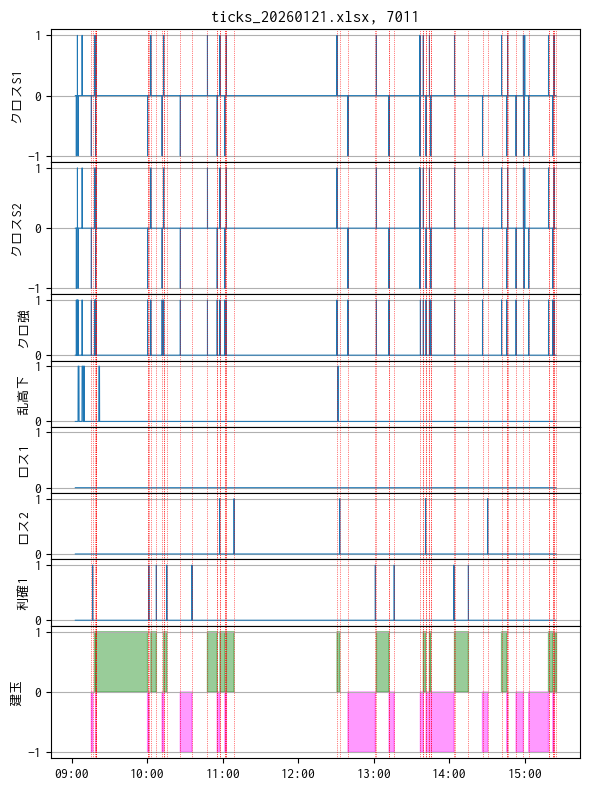

In [13]:
n = len(df_obs.columns)
fig = plt.figure(figsize=(6, n))
ax = dict()

targets = {"クロスS1", "クロスS2", "建玉"}
list_height_ratio = [2 if col in targets else 1 for col in df_obs.columns]
gs = fig.add_gridspec(n, 1, wspace=0.0, hspace=0.0, height_ratios=list_height_ratio)
for i, axis in enumerate(gs.subplots(sharex="col")):
    ax[i] = axis
    ax[i].grid(axis="y")

ax[0].set_title(f"{excel}, {code}")

special_cross = {"クロスS1", "クロスS2"}

for i, colname in enumerate(df_obs.columns):
    ax_i = ax[i]

    if colname in special_cross:
        ax_i.plot(df_obs[colname], linewidth=0.75)
        ax_i.set_ylim(-1.1, 1.1)

    elif colname == "建玉":
        x = df_obs.index
        y = df_obs[colname]
        ax_i.fill_between(
            x, 0, y, where=y > 0, color="green", alpha=0.4, interpolate=True
        )
        ax_i.fill_between(
            x, 0, y, where=y < 0, color="magenta", alpha=0.4, interpolate=True
        )
        ax_i.set_ylim(-1.1, 1.1)

    else:
        ax_i.plot(df_obs[colname], linewidth=0.75)
        ax_i.set_ylim(-0.1, 1.1)

    ax_i.set_ylabel(colname)
    ax_i.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

for i in range(n):
    for t in list_trans:
        ax[i].axvline(x=t, color="red", linestyle="dotted", linewidth=0.5)

plt.tight_layout()
output = os.path.join(output_dir, f"{code}_trend_obs.png")
print(output)
plt.tight_layout()
plt.savefig(output)
plt.show()